![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier ,export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
bikes['year'] = bikes.index.year
# Visualización
bikes

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour,year
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,2011
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,2011
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2,2011
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3,2011
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19,2012
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20,2012
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21,2012


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [5]:
bikes.groupby('workingday').total.sum()

workingday
0     654872
1    1430604
Name: total, dtype: int64

In [6]:
bikes.groupby('workingday').total.describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,3474.0,188.506621,173.724015,1.0,44.0,128.0,304.0,783.0
1,7412.0,193.011873,184.513659,1.0,41.0,151.0,277.0,977.0


Como podemos observar se incluye la función **describe** la cual informa sobre los datos estadísticos de un dataframe, esto con la finalidad de hacer una análisis mas completo. 
Partiendo de que la variable **workingday** nos denota por medio de un **1** si el día es un dia laboral (entre semana) y **0** si el día es feriado o fin de semana. A partir de esta variable vamos a ver su compartimiento con respecto a la variable de respuesta **total** que representa el número de aquiler de bicicletas totales, en base a lo anterior de tuvo el siguiente análisis:

* Se muestra que en los dias laborales (1) se tiene un total de alquileres de **1430604** respecto a los días no laborales (0) que tienen un total **654872** alquileres, esto nos refleja que hay mayor concurrencia o alquileres en los días laborales (entre semana) con un **68.59%** que en los no laborales con un **31.40%**.
* En las bicicletas alquiladas entre semana(1) se muestra un minímo de alquiler de **1** y un maximo de **977** (valor atípico o error de entrada de datos), se tiene una media de 193 con desviación de 184, es decir que por lo general se estara entre **8.5 y 377** de alquileres totales de bicicletas. Por ultimo podemos ver que el 75% de alquileres totales esta alrededor de 277.
* En las bicicletas alquiladas en fines de semana o festivos(0) se muestra un minímo de alquiler de **1** y un maximo de **783** (valor atípico o error de entrada de datos), se tiene una media de 188 con desviación de 173, es decir que por lo general se estara entre **15 y 3361** de alquileres totales de bicicletas. Por ultimo podemos ver que el 75% de alquileres totales esta alrededor de 304.

In [7]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [8]:
bikes.groupby('hour').total.sum()

hour
0      25088
1      15372
2      10259
3       5091
4       2832
5       8935
6      34698
7      96968
8     165060
9     100910
10     79667
11     95857
12    116968
13    117551
14    111010
15    115960
16    144266
17    213757
18    196472
19    143767
20    104204
21     79057
22     60911
23     40816
Name: total, dtype: int64

In [9]:
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


Como podemos observar se incluye la función **describe** la cual informa sobre los datos estadísticos de un dataframe, esto con la finalidad de hacer una análisis mas completo. 
Partiendo de que la variable **hour** nos denota las horas del día en el sistema horario de 24 horas. A partir de esta variable vamos a ver su compartimiento con respecto a la variable de respuesta **total** que representa el número de aquiler de bicicletas totales, en base a lo anterior de tuvo el siguiente análisis:

Se puede ver que dependiendo la hora el comportamiento de la variable total tiene cambios relevantes a tener en cuenta, como se describe a continuación:
 * Entre las 00:00 (media noche) y 06:00 de la mañana se puede observar que son horas en la que disminuye el alquiler de las bicicletas, pero cabe resaltar que en **ninguna hora** se deja de alquilar biciletas debido a que se mantiene un promedio de **32.298** en alquiler total.
 * La hora con el **menor alquilar** total de bicicletas es a las 04:00  realizando tan solo 2832 alquileres en total.
 * La hora con el **mayor alquilar** total de bicicletas es a las 17:00 am realizando 213757 alquileres en total, con un promedio de 468.
 * Se puede inferir que las horas con mayor promedio en alquiler de bicicletas son en horas picos, lo que quiere decir en las horas en las que se produce mayor aglomeración en los transportes o mayor demanda en usu de dterminados servicios o transporte publico.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

In [10]:
horas = pd.DataFrame(bikes.groupby('hour').total.mean())
horas['total']=horas['total'].apply(lambda x: round(x,2))


fig = px.bar(horas, x=horas.index, y="total", title="Promedio de alquiler de bicileta respecto a la hora", text_auto=True)
#fig.update_layout(xaxis_range=[0,25])
fig.update_traces(textfont_size=15, textangle=0, textposition="outside", cliponaxis=False)
fig.update_xaxes(title_text= "Hora")
fig.update_yaxes(title_text= "Número de alquileres totales")
fig.show()

<AxesSubplot:xlabel='hour'>

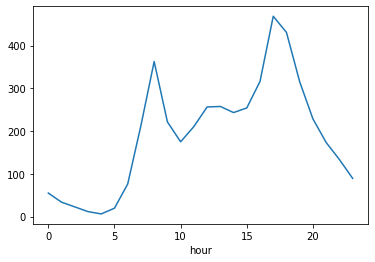

In [11]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

In [68]:
import plotly.io as pio
pio.renderers.default = 'notebook' 
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot
init_notebook_mode(connected=True)
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
workingday = pd.DataFrame(bikes.groupby(['workingday','hour']).total.mean())
workingday['total']=workingday['total'].apply(lambda x: round(x,2))
workingday.reset_index(level = [0,1], inplace=True)
workingday

# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
#workingday = workingday.query("workingday==0")
fig = px.line(workingday, x='hour', y="total", title="Promedio de alquiler de bicileta respecto a la hora", color='workingday',text="hour")
fig.update_traces(textposition="bottom right")
fig.update_xaxes(title_text= "Hora")
fig.update_yaxes(title_text= "Número de alquileres totales")
iplot(fig)

Con la anterior grafica se puede observar la linea roja la cual refleja los alquileres respecto a los dias laborales(1) y la linea azul los alquileres respecto a los días no laborales(0). A partir de esto podemos determinar que lo anterior descrito en el análisis númerico del punto anterior en donde se decia que **el promedio mas alto en el numero de alquiler de bicicletas se da en horas picos**, solo se cumple cuando "workingday" = 1, debido a que depronto mas personas utilizan las bicicletas como transporte publico paraa llegar a sus trabajos y estas horas son las de mayor concurrencia para entrar y salir del trabajo. Por otra parte se en los días no laborales se puede observar que las horas con mayor promedio de alquiler en bicicletas son entre las 12 del mediodia y las 4 de la tarde, ya que se puede inferir que son horas en donde los padres pueden pasear y alquilar bicicletas para estar con sus hijos.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [195]:
# Celda 3
# Variables predictoras
X = bikes[['hour', 'workingday']]
# Variable respuesta
y = bikes[['total']]
# split data
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
# creamos una instancia del modelo
regresion_lineal = LinearRegression() 
# Entreno el modelo con los datos (X,Y)
regresion_lineal.fit(xtrain, ytrain)
# vemos los parámetros que ha estimado la regresión lineal
print('w = ' + str(regresion_lineal.coef_) + ', b = ' + str(regresion_lineal.intercept_))


w = [[10.49958875  4.6623062 ]], b = [67.16293973]


Los coeficientes de regresión representan el cambio medio en la variable de respuesta para una unidad de cambio en la variable predictora mientras se mantienen constantes los otros predictores presentes en el modelo.
como se observa la variable w muestra los resultados de los dos coeficientes de las varriables predictoras, el primero muestra que el coeficiente para la hora en numero de alquiler de bicicleta es de 10.49, esto nos indica que por cada hora adicional se puede esperar que la cantidad de alquiler de bicicletas aumente un promedio de 10.49. 
El segundo muestra que el coeficiente para el tipo de día en numero de alquiler de bicicleta es de 4.66, esto nos indica que por cada tipo de dia se espera que la cantidad de alquiler de bicicletas aumente un promedio de 4.66.

In [191]:
from sklearn.metrics import mean_squared_error

# Predecimos los valores y para los datos usados en el entrenamiento
prediccion_test = regresion_lineal.predict(xtest)
# Calculamos el Error Cuadrático Medio (MSE = Mean Squared Error)
mse = mean_squared_error(y_true = ytest, y_pred = prediccion_test)
r2 = regresion_lineal.score(xtest, ytest)
print('Error Cuadrático Medio (MSE) = ' + str(mse))
print('Coeficiente de Determinación R2 = ' + str(r2))

Error Cuadrático Medio (MSE) = 27813.35560309556
Coeficiente de Determinación R2 = 0.15734814898229998


In [188]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = bikes[['hour', 'workingday','total']].select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(20)

,variable_1,variable_2,r,abs_r
2,hour,total,0.400601,0.400601
6,total,hour,0.400601,0.400601
5,workingday,total,0.011594,0.011594
7,total,workingday,0.011594,0.011594
1,hour,workingday,0.002780,0.002780
3,workingday,hour,0.002780,0.002780


Como podemos observar con tan solo estas varibles predictoras obtenemos un modelo poco eficiente con un Error Cuadrático Medio (MSE) muy alto y un coeficiente de determinación R2 bastante malo, el cual nos indica que la calidad del modelo para replicar resultados es bastante mala.
Las limitaciones de la regresión en este modelo son las pocas variables predictoras que describen su salida, la variable workinday no tiene una relación lineal con la variable respuesta.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [ ]:
# Variables predictoras
X = bikes[['hour', 'workingday']]
# Variable respuesta
y = bikes[['total']]
# split data
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [212]:
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [213]:
# Impresión variable a usar (hour)
j = 0
print(X.columns[j])

hour


In [214]:
# División de la variable hour en num_ctp puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

array([ 0.,  2.,  4.,  7.,  9., 12., 14., 16., 19., 21.])

In [215]:
# División de las observaciones usando el punto de corte en la posición 5 de la lista de splits
k=5
filter_l = X.iloc[:, j] < splits[k]

# División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
# y_l: la observación tiene un valor menor al punto de corte seleccionado
# y_r: la observación tiene un valor mayor o igual al punto de corte seleccionado
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [218]:
# Definición de la función que calcula el gini index
def gini(x):
    
    x = np.asarray(x)
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [219]:
# Gini index de las observaciones que tienen un valor menor al punto de corte seleccionado
gini_l = gini(y_l)
gini_l

0.6168947215170074

In [220]:
# Gini index de las observaciones que tienen un valor mayor o igual al punto de corte seleccionado
gini_r = gini(y_r)
gini_r

0.37072736837826786

In [221]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [222]:
# Ganancia de la variable 'Hour' en el punto de corte selecionado
gini_impurity(X.iloc[:, j], y, splits[k])

0.011268069382302959

In [225]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [245]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, )
j, split, gain

(0, 4.0, 0.04502291935496455)

El resultado anterior nos esta diciendo que la mejor ganancia es partir por la varriable 0, el split 6 y que con eso obtenemos un gini impurity de un 7.2%, que representa un gini bastante bueno.

In [246]:
# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

print("total y:",y.shape[0])
print("corte y rigth shape:",y_r.shape[0])
print("corte y left shape:",y_l.shape[0])


total y: 10886
corte y rigth shape: 9096
corte y left shape: 1790


In [247]:
print("y - promedio:",y.mean())
print("y rigth - promedio:", y_r.mean())
print("y left - promedio:",y_l.mean())

y - promedio: total    191.574132
dtype: float64
y rigth - promedio: total    223.138303
dtype: float64
y left - promedio: total    31.178771
dtype: float64


In [248]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [249]:
tree = tree_grow(xtrain, ytrain, level=0, min_gain=0.001, max_depth=6, num_pct=10)

In [242]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [244]:
# Predecimos los valores y para los datos usados en el entrenamiento
prediccion_test = tree_predict(xtest, tree)
# Calculamos el Error Cuadrático Medio (MSE = Mean Squared Error)
mse = mean_squared_error(y_true = ytest, y_pred = prediccion_test)
r2 = regresion_lineal.score(xtest, ytest)
print('Error Cuadrático Medio (MSE) = ' + str(mse))
print('Coeficiente de Determinación R2 = ' + str(r2))

Error Cuadrático Medio (MSE) = 69309.25711662075
Coeficiente de Determinación R2 = 0.15734814898229998


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [286]:
max_depth_range = range(1, 25)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
R2 = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeRegressor(max_depth=depth,random_state=1)
    R2.append(cross_val_score(clf, xtrain, ytrain, cv=10, scoring='r2').mean())


Text(0, 0.5, 'coeficiente de determinación R2')

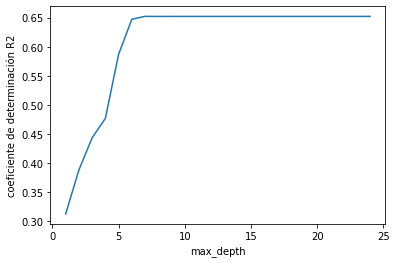

In [287]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, R2)
plt.xlabel('max_depth')
plt.ylabel('coeficiente de determinación R2')

In [289]:
# Predecimos los valores y para los datos usados en el entrenamiento
clf = DecisionTreeRegressor(max_depth=15, random_state=1)
clf.fit(xtrain,ytrain)
prediccion_test = clf.predict(xtest)
# Calculamos el Error Cuadrático Medio (MSE = Mean Squared Error)
mse = mean_squared_error(y_true = ytest, y_pred = prediccion_test)
r2 = regresion_lineal.score(xtest, ytest)
print('Error Cuadrático Medio (MSE) = ' + str(mse))
print('Coeficiente de Determinación R2 = ' + str(r2))

Error Cuadrático Medio (MSE) = 11829.16902245664
Coeficiente de Determinación R2 = 0.15734814898229998


Se puede observa que aunque utilizamos la libreria de sklearn y calibramos algunos parametros el resultado tuvo una mejoria muy pequeña respecto al arbol creado manualmente, esto se comparo en la partición de test por medio de dos métricas, las cuales son el error cuadrático medio y el coeficiente de determinación R2, en donde el se muestra que el modelo con menor desempeño es le modelo creado manualmente.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [13]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [14]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']


In [15]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [295]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 25)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []
score_f1 =[]

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    score_f1.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='f1').mean())


Text(0, 0.5, 'Accuracy')

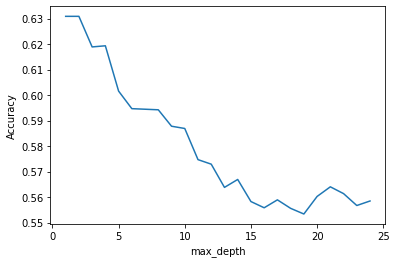

In [293]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Score-F1')

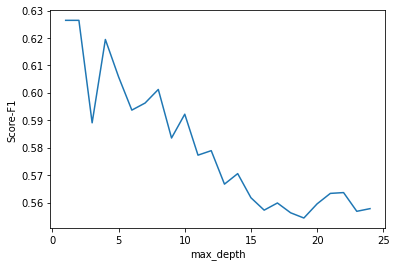

In [296]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, score_f1)
plt.xlabel('max_depth')
plt.ylabel('Score-F1')

In [30]:
# Celda 6
models = {'logisticRegression': LogisticRegression(random_state=1, solver ='saga', max_iter=10000),
          'decisionTree': DecisionTreeClassifier(max_depth=2, random_state=1)}


def performance_models(xtrain, ytrain, models): 
    # Entrenamiento (fit) de cada modelo
    for model in models.keys():
        models[model].fit(xtrain, ytrain)
    # Predicción de las observaciones del set de test para cada modelo
    y_pred = pd.DataFrame(index=X_test.index, columns=models.keys())
    for model in models.keys():
        y_pred[model] = models[model].predict(X_test)
    return y_pred

In [31]:
y_pred = performance_models(xtrain=X_train, ytrain=y_train, models= models)

for model in models.keys():
    print("Acurracy "+ "model "+model+":",accuracy_score(y_test,y_pred[model]))
    print("F1-Score "+ "model "+model+":",f1_score(y_test,y_pred[model]))

Acurracy model logisticRegression: 0.6106666666666667
F1-Score model logisticRegression: 0.6037991858887382
Acurracy model decisionTree: 0.6453333333333333
F1-Score model decisionTree: 0.6448598130841121


In [32]:
for model in models.keys():
    print("ReportC "+ "model "+model+":\n",classification_report(y_test, y_pred[model]))


ReportC model logisticRegression:
               precision    recall  f1-score   support

           0       0.60      0.63      0.62       744
           1       0.62      0.59      0.60       756

    accuracy                           0.61      1500
   macro avg       0.61      0.61      0.61      1500
weighted avg       0.61      0.61      0.61      1500

ReportC model decisionTree:
               precision    recall  f1-score   support

           0       0.64      0.65      0.65       744
           1       0.65      0.64      0.64       756

    accuracy                           0.65      1500
   macro avg       0.65      0.65      0.65      1500
weighted avg       0.65      0.65      0.65      1500



### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [34]:
models_vm = {'model 1': BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = None), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True),
            'model 2': BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 2), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True),
            'model 3': BaggingClassifier(base_estimator=LogisticRegression(solver='saga',max_iter=10000), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)}
            

In [35]:
y_pred_vm = performance_models(xtrain=X_train, ytrain=y_train, models= models_vm)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scip

In [38]:
for model in models_vm.keys():
    print("Acurracy "+ "model "+model+":",accuracy_score(y_test,y_pred_vm[model]))
    print("F1-Score "+ "model "+model+":",f1_score(y_test,y_pred_vm[model]))
    print("ReportC "+ "model "+model+":\n",classification_report(y_test, y_pred_vm[model]))

Acurracy model model 1: 0.64
F1-Score model model 1: 0.642384105960265
ReportC model model 1:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64       744
           1       0.64      0.64      0.64       756

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0.64      1500
weighted avg       0.64      0.64      0.64      1500

Acurracy model model 2: 0.6446666666666667
F1-Score model model 2: 0.6439545758183033
ReportC model model 2:
               precision    recall  f1-score   support

           0       0.64      0.65      0.65       744
           1       0.65      0.64      0.64       756

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0.64      1500
weighted avg       0.64      0.64      0.64      1500

Acurracy model model 3: 0.6126666666666667
F1-Score model model 3: 0.6044928522804629
ReportC model model 3:
               precision    reca

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [39]:
models_vp = {'model_4': BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = None), n_estimators=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True),
            'model_5': BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 2), n_estimators=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True),
            'model_6': BaggingClassifier(base_estimator=LogisticRegression(solver='saga',max_iter=10000), n_estimators=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)}

In [40]:
# Predicción y desempeño al hacer votación mayoritaria
y_pred_vp = performance_models(xtrain=X_train, ytrain=y_train, models= models_vp)

### Votación Mayoritaria

In [43]:
for model in models_vp.keys():
    print("Acurracy "+ "model "+model+":",accuracy_score(y_test,y_pred_vp[model]))
    print("F1-Score "+ "model "+model+":",f1_score(y_test,y_pred_vp[model]))
    print("ReportC "+ "model "+model+":\n",classification_report(y_test, y_pred_vp[model]))

Acurracy model model_4: 0.646
F1-Score model model_4: 0.6495049504950494
ReportC model model_4:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64       744
           1       0.65      0.65      0.65       756

    accuracy                           0.65      1500
   macro avg       0.65      0.65      0.65      1500
weighted avg       0.65      0.65      0.65      1500

Acurracy model model_5: 0.6473333333333333
F1-Score model model_5: 0.6456798392498325
ReportC model model_5:
               precision    recall  f1-score   support

           0       0.64      0.66      0.65       744
           1       0.65      0.64      0.65       756

    accuracy                           0.65      1500
   macro avg       0.65      0.65      0.65      1500
weighted avg       0.65      0.65      0.65      1500

Acurracy model model_6: 0.6133333333333333
F1-Score model model_6: 0.6054421768707483
ReportC model model_6:
               precision    re

### Votación Ponderada

In [60]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB

def votacion_ponderada(model):
    errors = np.zeros(model.n_estimators)
    y_pred_all_ = np.zeros((X_test.shape[0], model.n_estimators))

    for i in range(model.n_estimators):
        oob_sample = ~model.estimators_samples_[i]
        y_pred_ = model.estimators_[i].predict(X_train.values[oob_sample])
        errors[i] = accuracy_score(y_train.values[oob_sample], y_pred_)
        y_pred_all_[:, i] = model.estimators_[i].predict(X_test.values)
        
    alpha = (1 - errors) / (1 - errors).sum()
    y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)
    return y_pred

In [61]:
y_pred_model_4 = votacion_ponderada(model=models_vp['model_5'])
print("Acurracy "+ "model "+model+":",accuracy_score(y_test,y_pred_model_4))
print("F1-Score "+ "model "+model+":",f1_score(y_test,y_pred_model_4))
print("ReportC "+ "model "+model+":\n",classification_report(y_test, y_pred_model_4))

Acurracy model model_6: 0.646
F1-Score model model_6: 0.6504279131007242
ReportC model model_6:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64       744
           1       0.65      0.65      0.65       756

    accuracy                           0.65      1500
   macro avg       0.65      0.65      0.65      1500
weighted avg       0.65      0.65      0.65      1500



In [62]:
y_pred_model_5 = votacion_ponderada(model=models_vp['model_5'])
print("Acurracy "+ "model "+model+":",accuracy_score(y_test,y_pred_model_5))
print("F1-Score "+ "model "+model+":",f1_score(y_test,y_pred_model_5))
print("ReportC "+ "model "+model+":\n",classification_report(y_test, y_pred_model_5))

Acurracy model model_6: 0.6446666666666667
F1-Score model model_6: 0.6439545758183033
ReportC model model_6:
               precision    recall  f1-score   support

           0       0.64      0.65      0.65       744
           1       0.65      0.64      0.64       756

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0.64      1500
weighted avg       0.64      0.64      0.64      1500



In [63]:
y_pred_model_6 = votacion_ponderada(model=models_vp['model_6'])
print("Acurracy "+ "model "+model+":",accuracy_score(y_test,y_pred_model_6))
print("F1-Score "+ "model "+model+":",f1_score(y_test,y_pred_model_6))
print("ReportC "+ "model "+model+":\n",classification_report(y_test, y_pred_model_6))

Acurracy model model_6: 0.6113333333333333
F1-Score model model_6: 0.6031313818924439
ReportC model model_6:
               precision    recall  f1-score   support

           0       0.60      0.64      0.62       744
           1       0.62      0.59      0.60       756

    accuracy                           0.61      1500
   macro avg       0.61      0.61      0.61      1500
weighted avg       0.61      0.61      0.61      1500



### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [65]:
# votacion mayoritaria
model1= accuracy_score(y_test, y_pred_vm['model 1'])
model2= accuracy_score(y_test, y_pred_vm['model 2'])
model3= accuracy_score(y_test, y_pred_vm['model 3'])
# votacion ponderada
model4= accuracy_score(y_test,y_pred_model_4)
model5= accuracy_score(y_test,y_pred_model_5)
model6= accuracy_score(y_test,y_pred_model_6)

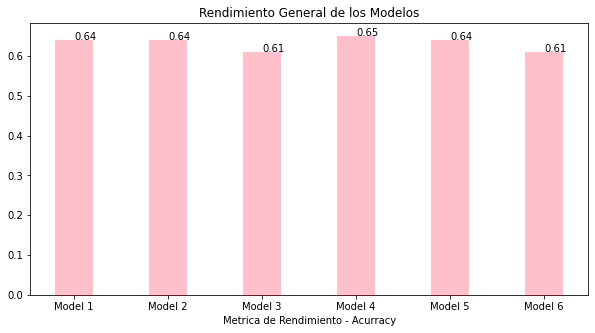

In [74]:
fig = plt.figure(figsize = (10, 5))

list_mse =[model1,model2,model3,model4,model5,model6]
list_mse = [round(x,2) for x in list_mse]
legens = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
plt.bar(legens, list_mse, color ='pink',
        width = 0.4)
plt.xlabel("Metrica de Rendimiento - Acurracy")
plt.title("Rendimiento General de los Modelos")
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(legens,list_mse,plt)
plt.show()

* Como podemos observar el rendimiento de los modelos es muy similar en cada uno de los casos propuestos en el punto 7 y 8.
* Una ventaja que ya sabemos que tienen los árboles de decisión es su fácil interpretabilidad. En un árbol resulta evidente cuales son los predictores más influyentes. Al utilizar bagging se mejora (mucho) la predicción, pero se pierde la interpretabilidad. Aunque para este caso no se evidencio gran mejoria.
* Una decisión que hay que tomar es cuántas muestras bootstrap se toman (o lo que es lo mismo, cuántos árboles se construyen).Si aparentemente hay convergencia con unos pocos cientos de árboles, no va a variar mucho el nivel de error al aumentar el número. Por tanto aumentar mucho el número de árboles no mejora las predicciones, aunque tampoco aumenta el riesgo de sobreajuste pero si se tiene un costo computacional mas alto, lo cual pudimos corroborar anteriormente en el punto debido a que por mas q se aumentara el número de arboles no se obtendria una mejora notable, pero si un costo computacional mayor.